# U-Net segmentation example
### Advanced Deep Learning 2022
This notebook was originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated [Stefan Sommer](mailto:sommer@di.ku.dk).

The U-Net is based on code written by Annika Brundyn and Akshay Kulkarni distributed as part of [*PyTorch Lightning Bolts*](https://pytorch-lightning.readthedocs.io/) under the  [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0.txt). 

We consider the data described in:

Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006


## Installs

If some packages are missing:

In [2]:
pip install -q pytorch_lightning lightning-bolts

     |████████████████████████████████| 584 kB 5.4 MB/s 
     |████████████████████████████████| 316 kB 48.5 MB/s 
     |████████████████████████████████| 409 kB 41.5 MB/s 
     |████████████████████████████████| 596 kB 42.1 MB/s 
     |████████████████████████████████| 136 kB 51.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.8 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 56.3 MB/s 
     |████████████████████████████████| 144 kB 51.7 MB/s 


## Imports

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn as nn
from torch.nn import functional as F
from torchvision.datasets.utils import download_url

import torchmetrics

from pprint import pformat
from skimage.transform import resize
#from sklearn.metrics import f1_score
from pathlib import Path
from glob import glob
from matplotlib.pyplot import imread
from collections import defaultdict

## Mount Google drive when using Google Colab

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/ADL2022')
except:
    print('Google drive not mounted')

Mounted at /content/gdrive/


## Test for GPU support

In [5]:
# GPU support?
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cuda:0


## U-Net
Import the U-Net.
  

In [6]:
from pl_bolts.models.vision import UNet

## Database

Load database with chest X-rays with lung segmentations.

In [7]:
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
  download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
  print('Using existing', data_fn)

Using existing ./datasets/lung_field_dataset.npz


In [8]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask
    
    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")
    
    ax.imshow(image.squeeze(), cmap="gray")
    mask = np.ma.masked_where(segmentation == 0, segmentation)
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax


def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

x train: (112, 1, 256, 256)
y train: (112, 1, 256, 256)
x val:  (12, 1, 256, 256)
y val:  (12, 1, 256, 256)
x test: (123, 1, 256, 256)
y test: (123, 1, 256, 256)


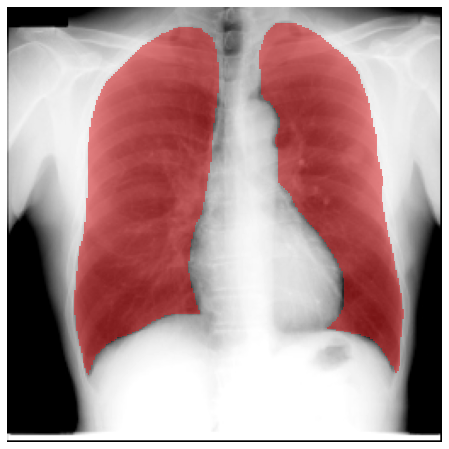

In [9]:
# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)
# Bring images into PyTorch format
x_train = np.moveaxis(x_train, 3, 1)
y_train = np.moveaxis(y_train, 3, 1)
x_val = np.moveaxis(x_val, 3, 1)
y_val = np.moveaxis(y_val, 3, 1)
x_test = np.moveaxis(x_test, 3, 1)
y_test = np.moveaxis(y_test, 3, 1)

print("x train:", x_train.shape)
print("y train:", y_train.shape)
print("x val: ", x_val.shape)
print("y val: ", y_val.shape)
print("x test:", x_test.shape)
print("y test:", y_test.shape)

# Plot an example
fig, ax = plot_image_with_segmentation(x_train[0], y_train[0])
plt.show()

### Init torch dataloaders

In [10]:
def as_torch_dataset(x_arr, y_arr):
    """
    Takes two numpy arrays of data points and labels (x_arr and y_arr, respectively) and
    returns a torch TensorDataset object.
    
    Returns: torch.utils.data.TensorDataset
    """
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(x_arr), 
        torch.LongTensor(y_arr)
    )
    return dataset

# Init torch datasets
train_dataset = as_torch_dataset(x_train, y_train.squeeze(1))  # remove dummy channel dim
val_dataset = as_torch_dataset(x_val, y_val.squeeze(1))
test_dataset = as_torch_dataset(x_test, y_test.squeeze(1))

# Init dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

### Function for evaluating a model on a data loader

In [11]:
def evaluate_model(model, data_loader, metrics_dict, reduction=True, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.
    On each batch, compute all metric functions stored in dictionary 'metrics_dict'.
    
    Returns: dict of metric_name: (list of batch-wise metrics if reduction == False, else single scalar)
    """
    
    # defaultdict(list) returns a dictionary-like object with default_factory list. 
    # When a new key is encountered, an entry is automatically created of type default_factory. 
    metrics = defaultdict(list)
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            # Predict on batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)
            
            # Compute all metrics
            for metric_name, metric_func in metrics_dict.items():
                value = metric_func(logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                metrics[metric_name].append(value)
    
    if reduction == True:
        # Return mean values
        return {key: np.mean(value) for key, value in metrics.items()}
    else:
        return metrics


## Main trainig loop function(s)

We want to track the F1 score during training. This generates some additional code. 

In [12]:
def run_one_epoch(model, loss, optimizer, train_loader, val_loader, n_epochs, metrics_dict, device=device):
    """
    Run 1 epoch of training
    Changes to model parameters and optimizer occour internally (state updates)
    Returns:
        two dictionaries, training and a validation metrics
    """
    train_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Zero out stored gradients for all parameters
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        
        # print(f"   -- Batch {i+1}/{len(train_loader)}", end=" / ")
        # Predict on batch
        logits = model(batch_x)
        
        # Compute loss function
        loss_tensor = loss(logits, batch_y)
        loss_scalar = loss_tensor.detach().cpu().numpy()
        train_losses.append(loss_scalar)
        
        # Backprop and step
        loss_tensor.backward()
        optimizer.step()
        
    # Run validation
    print("Loss: ", loss_scalar)
    # print("   Validation running...")
    val_metrics = evaluate_model(
        model=model, 
        data_loader=val_loader,
        metrics_dict=metrics_dict
    )
    # Return loss and metrics as dicts
    return {"loss": np.mean(train_losses)}, val_metrics


def merge_list_of_dicts(list_of_dicts):
    """
    Takes a list of dictionaries and merges them into a single dictionary pointing to lists
    
    E.g. [{"loss": 5}, {"loss": 3}, {"loss": -2, "F1": 0.5}] --> {"loss": [5, 3, -2], "F1": [0.5]}
    
    Returns: dict
    """
    merged = defaultdict(list)
    for dict_ in list_of_dicts:
        for value, key in dict_.items():
            merged[value].append(key)
    return merged


def training_loop(model, loss, optimizer, train_loader, val_loader, n_epochs, init_epoch=None, metrics_dict=None, save_path=None,verbose = True):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    Supports computing additional metrics on the validation set (only) via the metrics_dict param.
    Specify save_path to store the model at each epoch.
    
    Returns: 
        Two lists of metric dictionaries for each epoch for training and validation, specifically
    """
    train_history, val_history = [], []
    
    metrics_with_loss = {"loss": loss}
    if metrics_dict is not None:
        metrics_with_loss.update(metrics_dict)
    
    if init_epoch == None:
        init_epoch = 0
    try:
        for i in range(init_epoch, n_epochs):
            train_metrics, val_metrics = run_one_epoch(
                model=model, 
                loss=loss, 
                optimizer=optimizer, 
                train_loader=train_loader, 
                val_loader=val_loader, 
                n_epochs=n_epochs,
                metrics_dict=metrics_with_loss
            )
            if verbose:
                # print(f"Epoch {i+1}/{n_epochs}")
              print("   Mean epoch metrics:")
              print(f"   Training:   {pformat(train_metrics)}")
              print(f"   Validation: {pformat(val_metrics)}")
            train_history.append(train_metrics), val_history.append(val_metrics)
            
            if save_path:
                save_path_epoch = f"epoch_{i+1}_{save_path}"
                # print(f"   Saving to: {save_path_epoch}")
                save_model(model, save_path_epoch, optimizer)
        print("Done!")
    except KeyboardInterrupt:
        print("Training stopped.")
        pass
    
    # Merge list of training and validation dicts into single dicts    
    return merge_list_of_dicts(train_history), merge_list_of_dicts(val_history)


## Function for plotting training/validation histories

In [13]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)
    
    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)
    
    return fig, ax

## Functions for saving and loading model and optimizer state

In [14]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    return
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])


## Init U-Net model and optimizer

In [15]:

class UNet_adapted(nn.Module):
    """
    Paper: `U-Net: Convolutional Networks for Biomedical Image Segmentation
    <https://arxiv.org/abs/1505.04597>`_
    Paper authors: Olaf Ronneberger, Philipp Fischer, Thomas Brox
    Implemented by:
        - `Annika Brundyn <https://github.com/annikabrundyn>`_
        - `Akshay Kulkarni <https://github.com/akshaykvnit>`_
    Args:
        num_classes: Number of output classes required
        input_channels: Number of channels in input images (default 3)
        num_layers: Number of layers in each side of U-net (default 5)
        features_start: Number of features in first layer (default 64)
        bilinear: Whether to use bilinear interpolation or transposed convolutions (default) for upsampling.
    """

    def __init__(
        self,
        num_classes: int,
        input_channels: int = 3,
        num_layers: int = 5,
        features_start: int = 64,
        bilinear: bool = False,
        nearest: bool = False,
        elu: bool = False
    ):

        if num_layers < 1:
            raise ValueError(f"num_layers = {num_layers}, expected: num_layers > 0")

        super().__init__()
        self.num_layers = num_layers

        layers = [DoubleConv(input_channels, features_start)]

        feats = features_start
        for _ in range(num_layers - 1):
            layers.append(Down(feats, feats * 2))
            feats *= 2

        for _ in range(num_layers - 1):
            layers.append(Up(feats, feats // 2, bilinear))
            feats //= 2

        layers.append(nn.Conv2d(feats, num_classes, kernel_size=1))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        xi = [self.layers[0](x)]
        # Down path
        for layer in self.layers[1 : self.num_layers]:
            xi.append(layer(xi[-1]))
        # Up path
        for i, layer in enumerate(self.layers[self.num_layers : -1]):
            xi[-1] = layer(xi[-1], xi[-2 - i])
        return self.layers[-1](xi[-1])


class DoubleConv(nn.Module):
    """[ Conv2d => BatchNorm (optional) => ReLU ] x 2."""

    def __init__(self, in_ch: int, out_ch: int, elu : bool = False):
        super().__init__()


        if elu:
          act = nn.ELU(inplace=True)
        else:
          act = nn.ReLU(inplace=True)

        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            act,
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            act,
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """Downscale with MaxPool => DoubleConvolution block."""

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), DoubleConv(in_ch, out_ch))

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upsampling (by either bilinear interpolation or transpose convolutions) followed by concatenation of feature
    map from contracting path, followed by DoubleConv."""

    def __init__(self, in_ch: int, out_ch: int, bilinear: bool = False, nearest: bool = False):
        super().__init__()
        self.upsample = None

        if nearest:
          up = nn.Upsample(scale_factor=2, mode="nearest")
        else:
          up = nn.Upsample(scale_factor=2, mode="bilinear")

        self.upsample = nn.Sequential(
          up,
          nn.Conv2d(in_ch, in_ch // 2, kernel_size=1),
          )
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        # Pad x1 to the size of x2
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [16]:
# # Init U-Net model
# model = UNet_adapted(
#     num_classes=2, 
#     input_channels=1, 
#     num_layers=4, 
#     features_start=16,
# )

# model.to(device)

# Define optimizer
init_epoch = None

In [17]:
# model

## Continue training?

In [18]:
# Specify integer, starting at 1
# if init_epoch != None:
#     load_model(model, f"epoch_{init_epoch}_model.ckpt", optimizer)

## Run training

In [19]:
# # Define loss and metrics
# loss = torch.nn.CrossEntropyLoss(reduction="mean")
# metrics = {"f1": torchmetrics.classification.F1Score(num_classes=2, average="macro", mdmc_average="samplewise")}

# # Run training
# train_history, val_history = training_loop(
#     model=model,
#     loss=loss, 
#     optimizer=optimizer, 
#     train_loader=train_loader, 
#     val_loader=val_loader,
#     init_epoch=init_epoch,
#     n_epochs=100,
#     metrics_dict=metrics,
#     save_path="model.ckpt"
# )

## Plot training and validation histories

In [20]:
# plot_histories(train_history['loss'], val_history['loss'], label="Loss")
# plot_histories(train_history=None, val_history=val_history['f1'], label="F1 Score")
# plt.show()

## Evaluate on single test-set image

In [21]:
# # Predict on a test image
# x_test, y_test = test_dataset[0]
# if gpu:
#   x_test = x_test.to(device)
#   y_test = y_test.to(device)
# pred = model(x_test.view(1, 1, x_test.shape[1], x_test.shape[2])).argmax(1).cpu().numpy()

# # Plot the result
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
# ax1.set_title("True mask")
# ax2.set_title("Predicted mask")

# plot_image_with_segmentation(x_test.cpu(), y_test.cpu(), ax=ax1)
# plot_image_with_segmentation(x_test.cpu(), pred, ax=ax2)

# plt.show()

## Evaluate on whole test-set

In [22]:
# OBS: Returns batch-wise metrics, but test_loader has batch_size = 1
# f1_test_scores = evaluate_model(model, test_loader, metrics, reduction=False)["f1"]

# print("Test cases:", len(f1_test_scores))
# print("Mean F1:   ", np.mean(f1_test_scores))
# print("STD  F1:   ", np.std(f1_test_scores))
# print("Min. F1:   ", np.min(f1_test_scores))

The first runs gave:

Test cases: 123

Mean F1:    0.9739926723929925, 0.9723876545099708,0.9755190945253139

STD  F1:    0.016967003826433097, 0.014782506005475843, 0.014373308329103204

Min. F1:    0.9131132960319519, 0.9143620133399963, 0.9110709428787231


In [23]:
loss = torch.nn.CrossEntropyLoss(reduction="mean")
metrics = {"f1": torchmetrics.classification.F1Score(num_classes=2, average="macro", mdmc_average="samplewise")}

runtypes = ["normal","nearest","elu","nearest_elu"]


def base_model(nearest : bool, elu : bool):  
  return UNet_adapted(num_classes=2, input_channels=1, num_layers=4, features_start=16, nearest = nearest, elu = elu)

def get_model(runtype):
  if not runtype in runtypes:
    return False
  
  if runtype == "normal":
    return base_model(nearest = False, elu = False)
  if runtype == "nearest":
    return base_model(nearest = True, elu = False)
  if runtype == "elu":
    return base_model(nearest = False, elu = True)
  if runtype == "nearest_elu":
    return base_model(nearest = True, elu = True)

  return False

runs = {}

for run in runtypes:
    runs[run] = {'train_history':[],'val_history':[],'test_scores':[]}

def make_runs(n_runs):


    for runtype in runtypes:
        for i in range(n_runs):
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

            print("Training",runtype,i)
            model = get_model(runtype)

            model.to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

            train_history, val_history = training_loop(
                model=model,
                loss=loss, 
                optimizer=optimizer, 
                train_loader=train_loader, 
                val_loader=val_loader,
                init_epoch=init_epoch,
                n_epochs=300,
                metrics_dict=metrics,
                save_path="model.ckpt",
                verbose = False
            )


            f1_test_scores = evaluate_model(model, test_loader, metrics, reduction=False)["f1"]
            runs[runtype]['train_history'].append(train_history)
            runs[runtype]['val_history'].append(val_history)
            runs[runtype]['test_scores'].append(f1_test_scores)

make_runs(3)

Training normal 0
Loss:  0.7462097
Loss:  0.6904035
Loss:  0.6315477
Loss:  0.5834985
Loss:  0.55678344
Loss:  0.52836686
Loss:  0.5171725
Loss:  0.48487318
Loss:  0.4808105
Loss:  0.45040953
Loss:  0.44456443
Loss:  0.45026752
Loss:  0.44243434
Loss:  0.42826924
Loss:  0.42699042
Loss:  0.4318968
Loss:  0.4454881
Loss:  0.4231059
Loss:  0.4193781
Loss:  0.39929053
Loss:  0.3997165
Loss:  0.4054469
Loss:  0.40301016
Loss:  0.39768368
Loss:  0.40998903
Loss:  0.4060827
Loss:  0.38431185
Loss:  0.376276
Loss:  0.3874498
Loss:  0.3773956
Loss:  0.37971628
Loss:  0.36145222
Loss:  0.36280844
Loss:  0.35882956
Loss:  0.3508278
Loss:  0.37190896
Loss:  0.3731176
Loss:  0.37097746
Loss:  0.3492897
Loss:  0.3523072
Loss:  0.35031536
Loss:  0.32957402
Loss:  0.33737135
Loss:  0.34524935
Loss:  0.33329242
Loss:  0.3270544
Loss:  0.3304812
Loss:  0.32645884
Loss:  0.31414592
Loss:  0.32471612
Loss:  0.30942386
Loss:  0.32472825
Loss:  0.31455356
Loss:  0.3280514
Loss:  0.31111833
Loss:  0.2984605

In [24]:
np.save("xray_runs300epochs.npy",runs)

In [44]:
len(np.load("xray_runs200epochs.npy",allow_pickle = 1).item()["elu"]["train_history"][0]["loss"])

200